In [1]:
# Import the necessary libraries
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import skimage.io as io
from scipy import signal as sig
from commonfunctions import *  # this a custom module found the commonfunctions.
import pywt
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy
from skimage.morphology import dilation
from scipy import ndimage
from scipy.signal import wiener
from scipy.fftpack import dct


def show_images(images,titles=None):
    
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
%matplotlib inline

In [2]:
def preprocess(img):
    img = cv2.resize(img, (100, 100))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit = 4, tileGridSize=(5,5))
    final_img = clahe.apply(gray)
    return final_img




In [3]:
# # READ IMAGES FROM THE FOLDER HAPPY AND PREPROCESS THEM
import os

from sklearn.utils import shuffle

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

happy_images = load_images_from_folder('data/happy')


happy_images = [preprocess(img) for img in happy_images]

X = np.array(happy_images)
Y = np.zeros(X.shape[0])

sadness_images = load_images_from_folder('data/sadness')
sadness_images = [preprocess(img) for img in sadness_images]
X = np.concatenate((X, np.array(sadness_images)))
Y = np.concatenate((Y, np.ones(len(sadness_images))))

anger_images = load_images_from_folder('data/anger')
anger_images = [preprocess(img) for img in anger_images]
X = np.concatenate((X, np.array(anger_images)))
Y = np.concatenate((Y, np.ones(len(anger_images))+1))

fear_images = load_images_from_folder('data/fear')
fear_images = [preprocess(img) for img in fear_images]
X = np.concatenate((X, np.array(fear_images)))
Y = np.concatenate((Y, np.ones(len(fear_images))+2))

surprise_images = load_images_from_folder('data/surprise')
surprise_images = [preprocess(img) for img in surprise_images]
X = np.concatenate((X, np.array(surprise_images)))
Y = np.concatenate((Y, np.ones(len(surprise_images))+3))

# disgust_images = load_images_from_folder('data/disgust')
# disgust_images = [preprocess(img) for img in disgust_images]
# X = np.concatenate((X, np.array(disgust_images)))
# Y = np.concatenate((Y, np.ones(len(disgust_images))+4))

# contempt_images = load_images_from_folder('data/contempt')
# contempt_images = [preprocess(img) for img in contempt_images]
# X = np.concatenate((X, np.array(contempt_images)))
# Y = np.concatenate((Y, np.ones(len(contempt_images))+5))

class_names = ['Happy', 'Sadness', 'Anger', 'Fear', 'Surprised']
# ,'disgust', 'contempt'

# shuffle the data

zipped = list(zip(X, Y))

# Shuffle the zipped array
shuffled_zipped = shuffle(zipped)

# Unzip the shuffled array back into two arrays
X, Y = zip(*shuffled_zipped)

# show_images(X[:5], Y[:5])


print(np.unique(Y, return_counts=True))


(array([0., 1., 2., 3., 4.]), array([207,  84, 135,  75, 249], dtype=int64))


In [5]:
# import csv

# from sklearn.utils import shuffle

# # Open the CSV file
# filename=[]
# Y=[]
# with open('raf/list_patition_label.txt', 'r') as f:
#     # Create a CSV reader object
#     reader = csv.reader(f)
    
#     # Iterate over the rows of the file
    
#     for row in reader:
#         # in each row, the first element is the image name, the second  element is the label
#         # put the image name in the list of image names
#         # put the label in the list of labels
#         v = row[0].split('\t')
#         filename.append(v[0])
#         Y.append(v[1])
# X= []
# for i in filename:

#     temp = i[:-4]
#     i = temp+'_aligned.jpg'
#     img = cv2.imread('raf/aligned/'+i)
#     img = preprocess(img)
#     X.append(img)

# # we want to take 300 images from each class to make the training set
# # so check the number of images in each class
# # and take 300 images from each class
# # and put them in the training set
# Xnew = []
# Y_new = []
# for i in np.unique(Y):
#     count2=0
#     for j in range(len(Y)):
#         if Y[j] == i:
#             Xnew.append(X[j])
#             Y_new.append(Y[j])
#             # X.remove(X[j])
#             # Y.remove(Y[j])
#             count2+=1
#             if count2 == 300:
#                 break

        

# # shuffle the data

# zipped = list(zip(X, Y))

# # Shuffle the zipped array
# shuffled_zipped = shuffle(zipped)

# # Unzip the shuffled array back into two arrays
# X, Y = zip(*shuffled_zipped)
# print(np.unique(Y, return_counts=True))
# # show_images(X[:5], Y[:5])

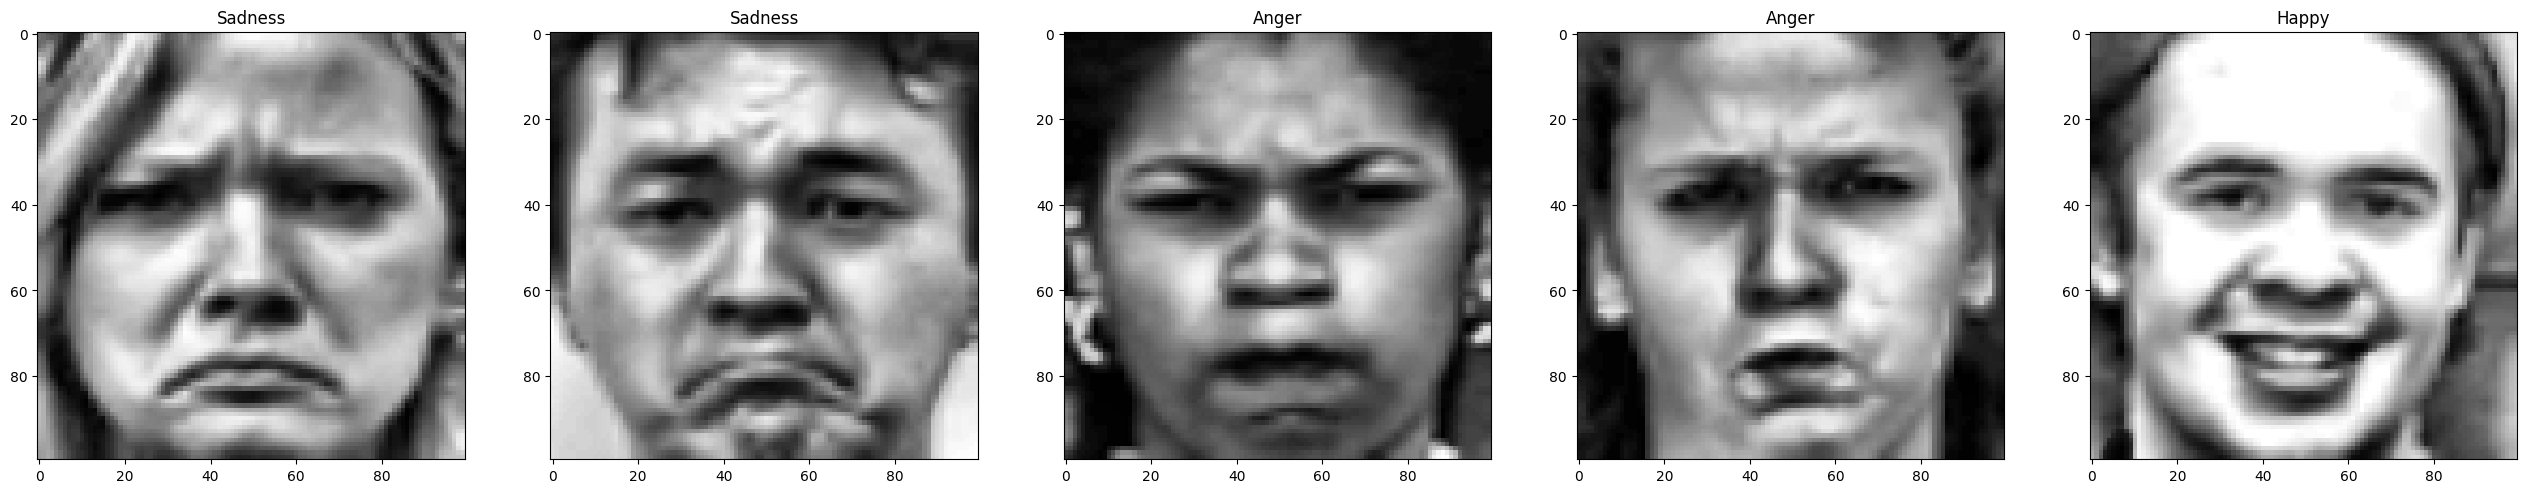

In [4]:
# print(np.unique(Y_new, return_counts=True))
# Xnew, Y_new = shuffle(Xnew, Y_new)

Y = np.array(Y)
# convert the labels to names from class_names
emotions = [class_names[int(i)] for i in Y]

show_images(X[:5],emotions[:5])
# print(Xnew.shape)
# print(Y.shape)


In [5]:
def pad_img(img,dec_lo):
    img = img.copy().astype(np.double)
    pad_width = len(dec_lo)//2
    img = pywt.pad(img, pad_width, 'periodic')

    return img, pad_width

def correct_dst_dim(swt_img):
    dst_dim = swt_img.shape[0]
    if dst_dim %2:
        dst_dim -= 1
    while pywt.swt_max_level(dst_dim) < 4:
        dst_dim-=2
    swt_img = cv2.resize(swt_img, (dst_dim, dst_dim))
    return swt_img

In [6]:
def detectemotion(roi_gray):
    wavelet = pywt.Wavelet('bior1.3')
    swt_img, pad_width =  pad_img(roi_gray, wavelet.dec_lo)
    # we need to pad the image to make sure the dimensions are correct when we do the SWT

    # we remove 2 pixels from the image to make sure that max_level is bigger than 4
    # so that we can do the SWT decomposition with 4 levels
    swt_img = correct_dst_dim(swt_img)


    coeffsAll = pywt.swt2(swt_img, wavelet, level=4, start_level=0)

    dCoeff = []
    aCoeff = []


    for id,coeffs2 in enumerate(coeffsAll):

        LL, (HL, LH, HH) = coeffs2

        LL = wiener(LL, mysize=(3,3))
        LH = wiener(LH, mysize=(3,3))
        HL = wiener(HL, mysize=(3,3))
        HH = wiener(HH, mysize=(3,3))


        # we need to take the absolute value of the coefficients to make sure that we don't have negative values
        LL = np.abs(LL)
        LH = np.abs(LH)
        HL = np.abs(HL)
        HH = np.abs(HH)

        
        # LL -= np.min(LL)
        # LH -= np.min(LH)
        # HL -= np.min(HL)
        # HH -= np.min(HH)
        


        # we need to normalize the coefficients to make sure that we don't have values bigger than 255
        LL = (255)*(LL/np.max(LL))
        LH = (255)*(LH/np.max(LH))
        HL = (255)*(HL/np.max(HL))
        HH = (255)*(HH/np.max(HH))

        # we need to convert the coefficients to integers
        LL = np.fix(LL)
        LH = np.fix(LH)
        HL = np.fix(HL)
        HH = np.fix(HH)

        # remove the padding that we added before the SWT decomposition 
        start = pad_width+pad_width//2
        end = -pad_width-pad_width//2-1
        LL = LL[start:end, start:end]
        LH = LH[start:end, start:end]
        HL = HL[start:end, start:end]
        HH = HH[start:end, start:end]

        coeffsAll[id] = (LL, LH, HL, HH)
        dCoeff.append((LH, HL, HH))
        aCoeff.append(LL)



    # %% [markdown]
    # 5) Apply wiener filter to all subbands by
    # equation 6 to reduce the high frequency
    # components effect.

    # %%
    coeffsAll=np.array(coeffsAll)
    dCoeff=np.array(dCoeff)
    aCoeff=np.array(aCoeff)
    coeffsAll = coeffsAll[::-1]
    dCoeff = dCoeff[::-1]
    aCoeff = aCoeff[::-1]

    # 6) Estimate the local energy in each
    # coefficient of detailed subbands by
    # equation 8.

    E = dCoeff**2

    # 7) For each subband, calculate the mean
    # local energy wavelet subband and
    # maximum local energy wavelet subband
    # using equation 9 & 10.
    filter = np.ones((3,3))
    LEmax = E
    LEmu = E
    for i in range(4):
        for j in range(3):
            LEmu[i,j] = ndimage.uniform_filter(LEmu[i,j], size=3)
            # To get the maxima of the local energy, we dilate the local energy
            LEmax[i,j] = dilation(LEmax[i,j], filter)


    LEmax = (255)*(LEmax/np.max(LEmax))
    LEmu = (255)*(LEmu/np.max(LEmu))


    # 8) Evaluate pixel level fusion to the local
    # energy wavelet subbands to obtain a
    # combination set of subbands Skj(a,b)
    # (k=1,2…..,6 & j=1,2,3,4) by equations
    # 11-14.

    # %%
    # Equations from 12 to 14
    u = np.zeros((4, 1))
    v = np.zeros((4, 1))
    w = np.zeros((4, 1))
    for j in range(4):
        u[j] = np.sum(0.5*(1+np.corrcoef(coeffsAll[j][0], coeffsAll[j][1])))
        v[j] = np.sum(0.5*(1+np.corrcoef(coeffsAll[j][0], coeffsAll[j][2])))
        w[j] = np.sum(0.5*(1+np.corrcoef(coeffsAll[j][0], coeffsAll[j][3])))

    # %%
    # Equation 11
    Skj = np.zeros((6, 4, E.shape[2], E.shape[3]))
    for j in range(4):
        Skj[0,j] = u[j]*LEmu[j,0]+v[j]*LEmu[j,1]
        Skj[1,j] = u[j]*LEmu[j,0]+w[j]*LEmu[j,2]
        Skj[2,j] = v[j]*LEmu[j,1]+w[j]*LEmu[j,2]
        Skj[3,j] = u[j]*LEmax[j,0]+v[j]*LEmax[j,1]
        Skj[4,j] = u[j]*LEmax[j,0]+w[j]*LEmax[j,2]
        Skj[5,j] = v[j]*LEmax[j,1]+w[j]*LEmax[j,2]

    Skj = (255)*(Skj/np.max(Skj))
    # %% [markdown]
    # 9) Calculate the entropy value of all
    # subbands using equation 15. The
    # selections of subbands are made by the
    # consideration of maximal entropy
    # values. Se(a,b) (e=1,2….,15)

    # %%
    # shannon entropy from equation 15
    H = np.zeros((6,4))
    for k in range(6):
        for j in range(4):
            H[k,j] = shannon_entropy(Skj[k,j])

    H = H.flatten()
    H_id= H.argsort()[::-1]

    Se = Skj.reshape((24, E.shape[2], E.shape[3]))
    Se = Se[H_id[:15]]

    Se = (255)*(Se/np.max(Se))
    # %% [markdown]
    # 10)Apply 8x8 block dct to all selected
    # subbands and the dc coefficient obtained
    # in each block alone is retained so that the
    # size of each subband is changed to
    # Sr(m,n). Here mxn = d<<axb, d is the
    # number of dc coefficients obtained in
    # each subband.

    
    Sr = np.zeros((15,E.shape[2], E.shape[3]))
    for i in range(15):
        Sr[i] = dct(Se[i], norm='ortho')

    # osize= (Se.shape[1] - 8)//8+1

    # Sr = np.zeros((15,osize,osize))
    # k=8
    # for r in range(15):
    #     for i in range(osize):
    #     # Iterate over the columns
    #         for j in range(osize):
    #             # img[i, j] = individual pixel value
    #             # Get the current matrix
    
                
    #             mat = Se[r, i:i+k, j:j+k]
                
    #             # Apply the convolution - element-wise multiplication and summation of the result
    #             # Store the result to i-th row and j-th column of our convolved_img array
    #             Sr[r, i, j] = dct(mat.flatten())[0]
    
    # %% [markdown]
    # 11) The statistical parameters such as mean,
    # standard deviation, covariance, median,
    # energy, skewness and kurtosis are
    # estimated from each subband and is
    # switched to one dimensional vector with
    # size of 1x105 (seven parameters from 15
    # subbands 7x15=105) which forms
    # feature vector Fimg

    # %%
    Fimg = np.zeros((15, 7))
    for r in range(15):
        Fimg[r, 0] = np.mean(Sr[r])
        Fimg[r, 1] = np.std(Sr[r])
        Fimg[r, 2] = np.var(Sr[r])
        Fimg[r, 3] = np.median(Sr[r])
        Fimg[r, 4] = np.sum(np.square(Sr[r]))
        Fimg[r, 5] = skew(Sr[r], axis=None)
        Fimg[r, 6] = kurtosis(Sr[r], axis=None)




    return Fimg.flatten()



In [7]:
x=[]
count=0
# Xnew=np.array(Xnew)
# print(Xnew.shape)
for i in X:
    count+=1
    x.append(detectemotion(i))
x=np.array(x)

c:\Users\Lenovo\anaconda3\lib\site-packages\scipy\signal\_signaltools.py:1625: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
c:\Users\Lenovo\anaconda3\lib\site-packages\scipy\signal\_signaltools.py:1625: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [8]:
# save the features in a file to use it later
np.save('Ckplus_features.npy', x)

# load the features from the file
# x = np.load('features_rpf.npy')

print(x.shape)


(750, 105)


In [12]:

xnew= []

from sklearn.decomposition import PCA

temp = x.copy()

for i in temp:
    xnew.append(i.flatten())

xnew = np.array(xnew)
# print(xnew.shape)
# for each column in xnew, normalize it
mean,variance =np.zeros((105,)),np.zeros((105,))


for i in range(len(xnew[0])):
    mean[i] = np.mean(xnew[:,i])
    variance[i] = np.std(xnew[:,i])
    xnew[:,i] = (xnew[:,i] - np.mean(xnew[:,i])) / np.std(xnew[:,i])
pca = PCA(n_components=35) 
pca.fit(xnew)
Fimg = pca.transform(xnew)

print(Fimg.shape)

# xnew = np.array(xnew)



(750, 35)


In [287]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

clf = SVC(kernel='poly', degree=2, C=150)
# clf = SVC(kernel='rbf', C=100, gamma=1)

# split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(Fimg, Y, test_size=0.1,stratify=Y)


clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
y_pred_train = clf.predict(x_train)

# print(y_pred_train.shape)
class_counts = np.unique(y_pred, return_counts=True)[1]



# Plot the class frequencies in a bar chart
# plt.bar(range(len(class_counts)), class_counts)
# plt.xlabel('Class')
# plt.ylabel('Frequency')
# plt.show()
# Evaluate the classifier

accuracy = accuracy_score(y_test, y_pred)*100
print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 93.33


In [189]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, y_pred)

print(confusion_mat)

[[40  0  0  0  1]
 [ 3 11  1  1  1]
 [ 0  1 23  1  2]
 [ 2  2  0 10  1]
 [ 4  4  2  2 38]]


In [9]:
# Save the model
from sklearn.metrics import f1_score
import pickle
# pickle.dump(clf, open('model93.pkl', 'wb'))

# Load the model
model = pickle.load(open('model85.pkl', 'rb'))
# y_pred_model = model.predict(x_test)

# f1_value = accuracy_score(y_test, y_pred_model)*100
# print(f1_value)

In [10]:
def detect_faces(test_image, scaleFactor = 1.1):

    haar_cascade_face = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')

    # create a copy of the image to prevent any changes to the original one.
    image_copy = test_image.copy()
    
    #convert the test image to gray scale as opencv face detector expects gray images
    # gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    
    # Applying the haar classifier to detect faces
    faces_rect = haar_cascade_face.detectMultiScale(image_copy, scaleFactor=scaleFactor, minNeighbors=5)
    # return image of each detected face
    faces = []
    for (x, y, w, h) in faces_rect:
        faces.append(image_copy[y:y+h, x:x+w])


    for (x, y, w, h) in faces_rect:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return faces

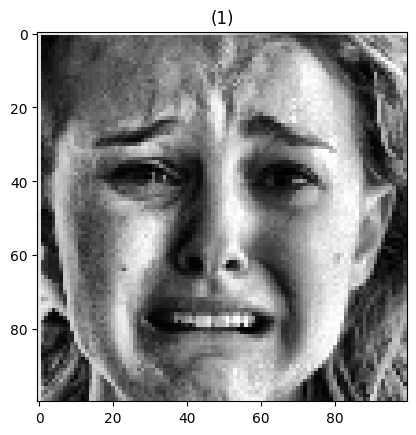

Sadness


In [13]:
# print(y_test)

test_image2=  cv2.imread('test/6af89d8db72d8c4638648fef0143ac7f.jpg')

faces2 = detect_faces(test_image2)
test_image2 = preprocess(faces2[0])
# faces2 = np.array(faces2)

show_images([test_image2])

m= detectemotion(test_image2)

for i in range(len(m)):
    m[i] = (m[i] - mean[i]) /variance[i]

# print(m)
m = pca.transform([m.flatten()])


print(class_names[(int)(model.predict(m))])


In [14]:

test_image= load_images_from_folder('test')

faces_test = [detect_faces(img) for img in test_image]
faces_test = np.array(faces_test)
print(faces_test.shape)
faces = [preprocess(img[0]) for img in faces_test]
faces=np.array(faces)
m=[]
for(img) in faces:
    m.append(detectemotion(img))



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12372\2879544131.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  faces_test = np.array(faces_test)


(20, 1)


c:\Users\Lenovo\anaconda3\lib\site-packages\scipy\signal\_signaltools.py:1625: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
c:\Users\Lenovo\anaconda3\lib\site-packages\scipy\signal\_signaltools.py:1625: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [15]:
results = []
m2 = np.copy(m)
for i in m2:
    results.append(i.flatten())

results = np.array(results)


for i in range(len(results[0])):
    results[:, i] = (results[:, i] - mean[i]) / variance[i]


results = pca.transform(results)
expected = ["Happy","Sadness","Happy","Sadness" ,"Happy","Happy","Sadness","Happy","Fear", "Anger","Sadness" ,"Anger", "Fear","Fear","Fear","Happy", "Surprised","Surprised","Surprised", "Happy"
            ]

y = model.predict(results)
print("Result     Expected\n")
count=0
accuracy=0
for i in y:
    print(class_names[(int)(i)] +"      "+ expected[count])
    if(class_names[(int)(i)] == expected[count]):
        accuracy+=1
    count+=1
accuracy = (accuracy/count)*100
print("Accuracy: "+ str(accuracy) + "%")

Result     Expected

Happy      Happy
Sadness      Sadness
Happy      Happy
Sadness      Sadness
Happy      Happy
Happy      Happy
Anger      Sadness
Happy      Happy
Surprised      Fear
Anger      Anger
Anger      Sadness
Anger      Anger
Surprised      Fear
Happy      Fear
Fear      Fear
Happy      Happy
Surprised      Surprised
Surprised      Surprised
Surprised      Surprised
Surprised      Happy
Accuracy: 70.0%
